In [47]:
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
from scipy.stats import mannwhitneyu, ttest_ind, pearsonr, spearmanr
from tqdm import tqdm
import numpy as np 
import math
import seaborn as sns
from scipy.stats import ttest_ind


demos = ['women', 'black', 'hispanic', 'native american']
%matplotlib inline
# hard coded it because of assignment errors

In [2]:
def startup():
    all_unis = {}
    all_completions = {}
    unis = pd.read_csv('../../data/IPEDS/university_info/hd2021.csv', encoding='cp1252')
    for year in range(2008, 2022):
        all_unis[year] = unis
        all_completions[year] = pd.read_csv('../../data/IPEDS/completions/c%s_a.csv' % year)
        all_unis[year].set_index('UNITID')
        all_completions[year].set_index('UNITID')
    demo_names = ['CTOTALW', 'CAIANT', 'CBKAAT', 'CHISPT']
    return all_unis, all_completions, demo_names

In [3]:
def make_years(completions, unis, start, end):
    years = {}
    for year in range(start, end + 1):
        year_completions, year_unis = unis[year], completions[year]
        years[year] = [year_completions, year_unis]
    return years

In [17]:
# data is the dataframe already boolmapped with the proper data
def groupTotals(years):
    allStateCsData  = []
    allStateNonCsData = []
    for year in years:
        unis, data = years[year]
        csMerge, nonCsMerge = csVsNonCs(data, unis)
        csMerge['year'] = year
        nonCsMerge['year'] = year
        csMerge.set_index('UNITID')
        nonCsMerge.set_index('UNITID')
        allStateCsData.append(csMerge)
        allStateNonCsData.append(nonCsMerge)
    allStateCsData = pd.concat(allStateCsData)
    allStateNonCsData = pd.concat(allStateNonCsData)
    return allStateCsData, allStateNonCsData
    
        
        
def csVsNonCs(data, unis):
    data = data.reset_index()
    csBoolmap = data['CIPCODE'].apply(lambda x : x < 12 and x >= 11)
    cs = data[csBoolmap]
    csSum = cs.groupby('UNITID').sum()
    csSum = csSum.reset_index()
    uniqueIds = set(csSum['UNITID'].unique())
    nonCs = data[data.apply(lambda x: x['UNITID'] in uniqueIds, axis = 1)]
    nonCsSum = nonCs.groupby('UNITID').sum().reset_index()
    cols = ['UNITID', 'CTOTALW', 'CAIANT', 'CBKAAT', 'CHISPT', 'CTOTALT']
    csMerge = pd.merge(csSum[cols], unis['UNITID'], on = 'UNITID', how='left')
    nonCsMerge = pd.merge(nonCsSum[cols], unis['UNITID'], on = 'UNITID', how='left')
    return csMerge, nonCsMerge

In [16]:
def make_percents(cs, nonCs):
    cs = cs.set_index(['UNITID', 'year'])
    nonCs = nonCs.set_index(['UNITID', 'year'])
    cs = cs.apply(lambda x: x / x['CTOTALT'], axis = 1)
    nonCs = nonCs.apply(lambda x: x / x['CTOTALT'], axis = 1)
    return cs, nonCs

In [6]:
def cs_nonCs_difference(cs, nonCs):
    difference = cs - nonCs
    difference.columns = ['d_%s' % col for col in difference.columns]
    return difference

In [7]:
def get_avg(data):
    data = data.reset_index()
    data = data.groupby('UNITID').mean()
    return data

In [8]:
def make_correlation_df(data, unis, demo):
    correlation_df_merge = pd.merge(data[['d_CTOTALW', 'd_CBKAAT', 'd_CHISPT', 'd_CAIANT']], unis)
    non_differences = correlation_df_merge.drop(['d_CTOTALW', 'd_CBKAAT', 'd_CHISPT', 'd_CAIANT'], axis=1)
    correlations_df = non_differences.corrwith(correlation_df_merge[demo])
    return correlations_df.dropna()
    


In [9]:
def binarize(data, unis, col):
    series = unis[col]
    unique_vals = set(series.unique())
    #binarized_unis = pd.DataFrame()
    for value in unique_vals:
        data['%s_%s'%(col, value)] = (unis[col] == value).astype(int)

In [10]:
def demo_df(all_unis):
    binarized_unis = pd.DataFrame()
    
    cols = ['SECTOR', 'INSTSIZE', 'UGOFFER', 'GROFFER', 'HBCU', 'HDEGOFR1', 'MEDICAL', 'LOCALE', 'C21BASIC', 'CBSATYPE', 'C21SZSET']
    for col in cols:
        binarize(binarized_unis, all_unis[2021], col)
    binarized_unis['UNITID'] = all_unis[2021]['UNITID']
    binarized_unis = binarized_unis.set_index('UNITID')
    return binarized_unis


In [11]:
def difference_df(difference, df):
    final_df = pd.merge(difference, df, left_index=True, right_index=True)

In [71]:
all_unis, all_completions, demo_names = startup()
years = make_years(all_completions, all_unis, 2011, 2021)
cs_group, nonCs_group = groupTotals(years)
cs_percent, nonCs_percent = make_percents(cs_group, nonCs_group)
# difference = cs_nonCs_difference(cs_percent, nonCs_percent)
# average = get_avg(difference)
binarized_unis = demo_df(all_unis)
# binarized_df = difference_df(average, binarized_unis)


/var/folders/b5/xk6gdm191jgfc3mj34jg7zbh0000gn/T/ipykernel_99107/3321307802.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s'%(col, value)] = (unis[col] == value).astype(int)
/var/folders/b5/xk6gdm191jgfc3mj34jg7zbh0000gn/T/ipykernel_99107/3321307802.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s'%(col, value)] = (unis[col] == value).astype(int)
/var/folders/b5/xk6gdm191jgfc3mj34jg7zbh0000gn/T/ipykernel_99107/3321307802.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the

In [72]:
cs_percent = cs_percent.reset_index()
nonCs_percent = nonCs_percent.reset_index()
cs_percent = cs_percent[cs_percent['year'] >= 2011]
nonCs_percent = nonCs_percent[nonCs_percent['year'] >= 2011]

In [75]:
eleven = cs_percent['UNITID'].value_counts()
eleven = eleven[eleven == 11]
cs_percent = cs_percent.dropna()
nonCs_percent = nonCs_percent.dropna()
cs_percent = cs_percent[cs_percent['UNITID'].apply(lambda x: x in eleven.index)]
non_cs_eleven = nonCs_percent['UNITID'].value_counts()
non_cs_eleven = non_cs_eleven[non_cs_eleven == 11]
nonCs_percent = nonCs_percent[nonCs_percent['UNITID'].apply(lambda x: x in eleven.index)]

In [84]:
cs_trends = cs_percent.groupby('UNITID').apply(lambda x: pearsonr(x['year'], x['CBKAAT']))
cs_trends = cs_trends.apply(lambda x: pd.Series({'cs_stat': x[0], 'cs_pval': x[1]}))
nonCs_trends = nonCs_percent.groupby('UNITID').apply(lambda x: pearsonr(x['year'], x['CBKAAT']))
nonCs_trends = nonCs_trends.apply(lambda x: pd.Series({'nonCs_stat': x[0], 'nonCs_pval': x[1]}))
trends = pd.merge(cs_trends, nonCs_trends, left_index=True, right_index=True)

/Users/masontaylor/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/masontaylor/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [95]:
unis = pd.read_csv('../../data/IPEDS/university_info/binarized_hd_2021.csv', index_col = 0)
unis_stats = pd.merge(unis, trends, left_index=True, right_index=True)
unis_stats = unis_stats.dropna()

In [96]:
unis_stats.sort_values('nonCs_stat')

,SECTOR_0,SECTOR_1,SECTOR_2,SECTOR_3,SECTOR_4,SECTOR_5,SECTOR_6,SECTOR_7,SECTOR_8,SECTOR_9,...,C21SZSET_14,C21SZSET_15,C21SZSET_16,C21SZSET_17,C21SZSET_18,C21SZSET_-2,cs_stat,cs_pval,nonCs_stat,nonCs_pval
UNITID,,,,,,,,,,,,,,,,,,,,,
135717,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,-0.429268,0.187658,-0.977488,2.183860e-07
190691,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,-0.544193,0.083507,-0.974640,3.717482e-07
190567,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,-0.043815,0.898218,-0.970409,7.398468e-07
134130,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,-0.109790,0.747949,-0.968895,9.241042e-07
190655,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,-0.811795,0.002410,-0.964829,1.596716e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196060,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0.903119,0.000139,0.980449,1.162842e-07
229115,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0.876539,0.000399,0.984700,3.881260e-08
149772,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.274843,0.413391,0.986946,1.906134e-08


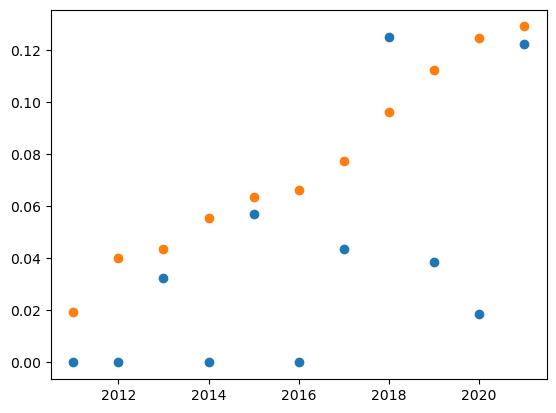

In [91]:
oneCs = cs_percent[cs_percent['UNITID'] == 212115]
one_nonCs = nonCs_percent[nonCs_percent['UNITID'] == 212115]
plt.scatter(oneCs['year'], oneCs['CBKAAT'])
plt.scatter(one_nonCs['year'], one_nonCs['CBKAAT'])


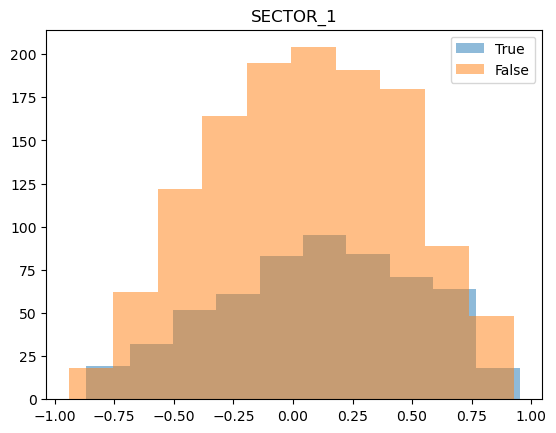

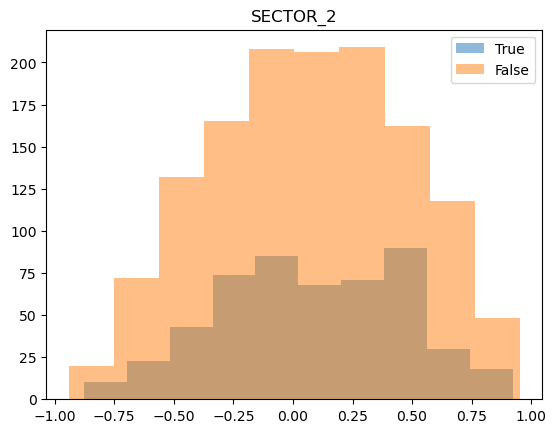

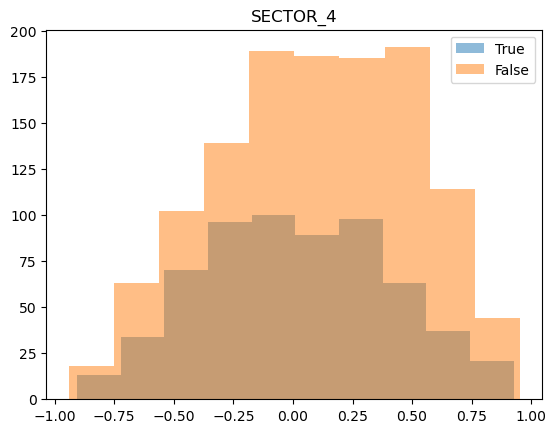

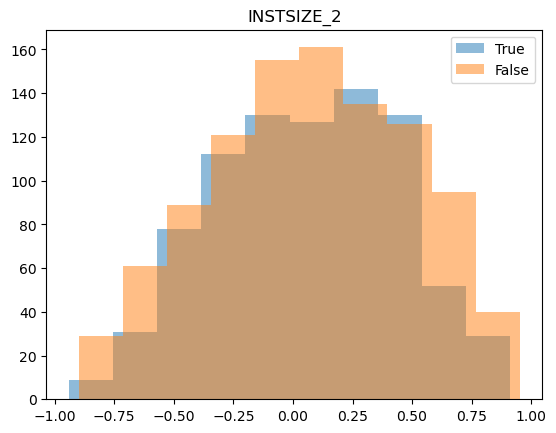

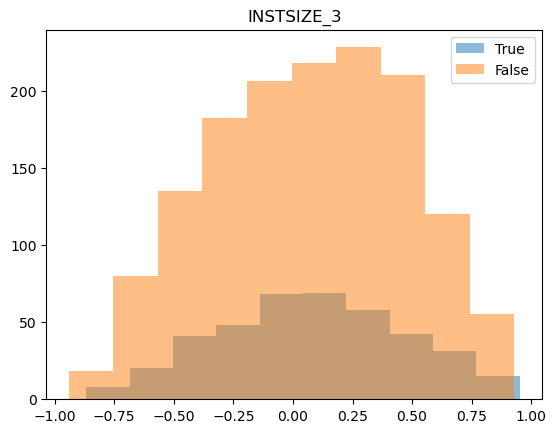

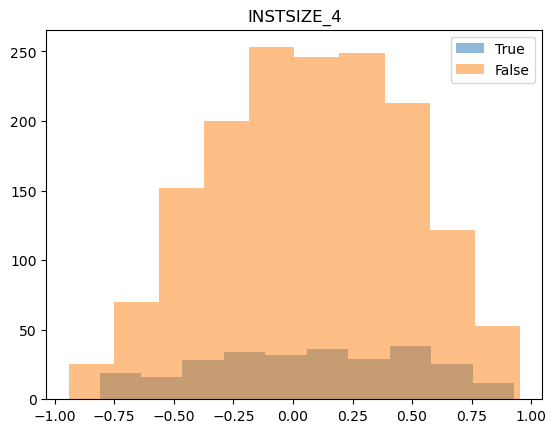

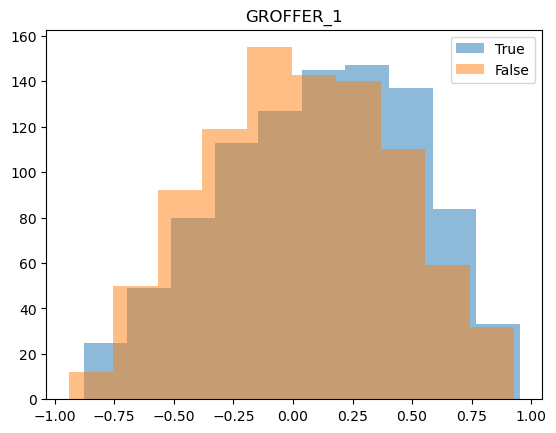

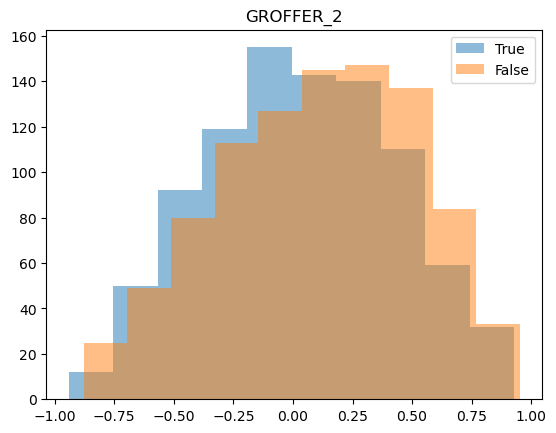

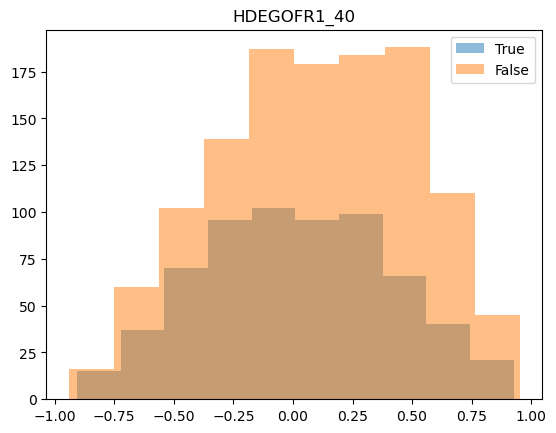

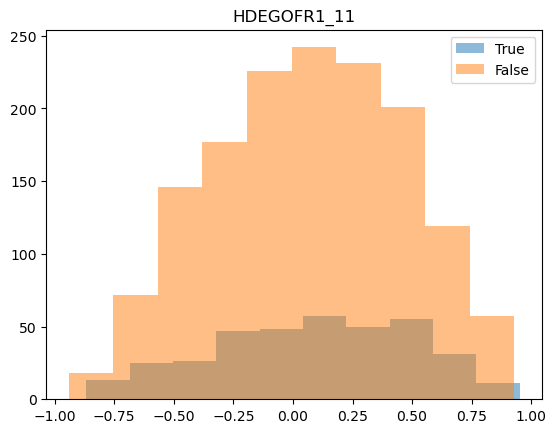

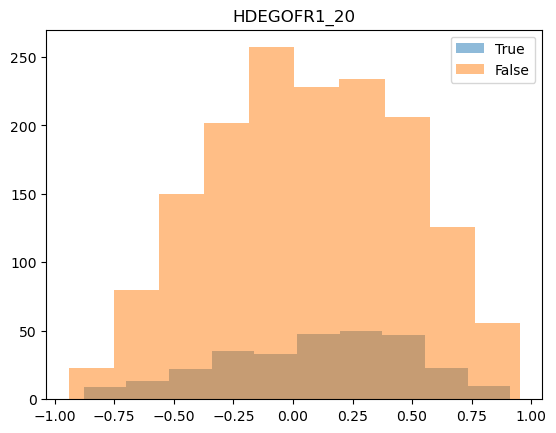

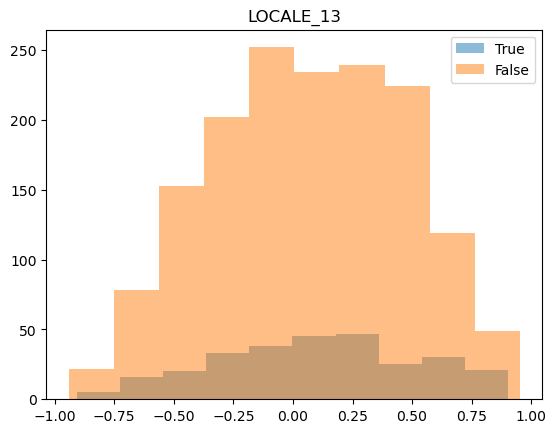

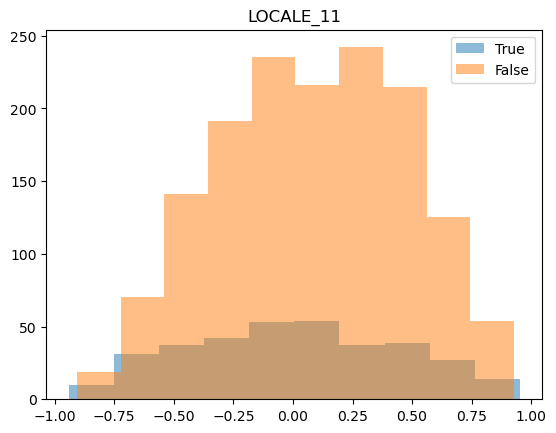

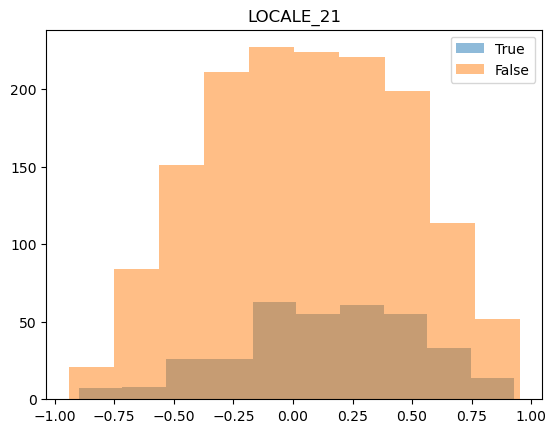

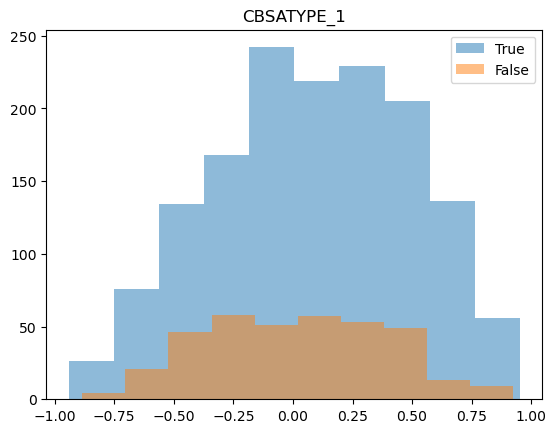

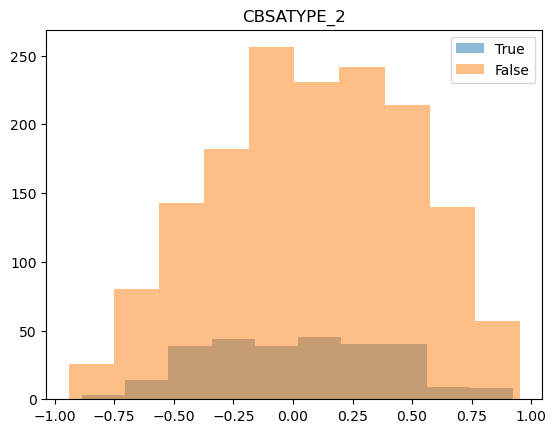

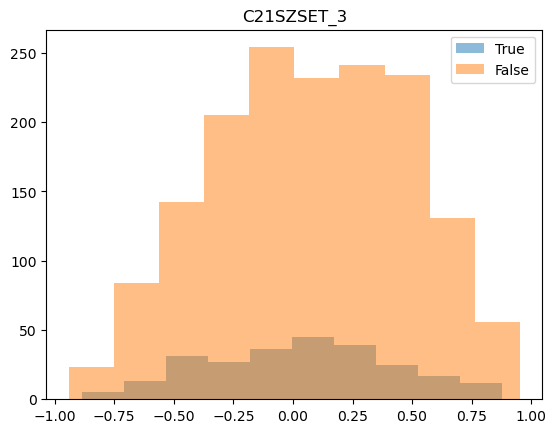

<Figure size 640x480 with 0 Axes>

In [103]:
demo_cols = ['d_CTOTALW', 'CBKAAT', 'CHISPT', 'CAIANT']
#for demo in demo_cols:
results = []
for col in binarized_unis.columns.unique():
    pos = unis_stats.loc[unis_stats[col] == 1, 'cs_stat']
    neg = unis_stats.loc[unis_stats[col] == 0, 'cs_stat']
    min_length = min(len(pos), len(neg))
    if min_length < 250:
        continue
    stat, pval = ttest_ind(pos, neg, equal_var=False, alternative='two-sided')
    results.append([col, pval])
results = pd.DataFrame(results)
results.columns = ['col', 'pval']
results = results.dropna()
results.sort_values('pval')
for col in results['col'].values:
    pos = unis_stats.loc[unis_stats[col] == 1, 'cs_stat']
    neg = unis_stats.loc[unis_stats[col] == 0, 'cs_stat']
    plt.hist(pos, alpha = 0.5, label = 'True')
    #plt.figure()
    plt.hist(neg, alpha = 0.5, label = 'False')
    #plt.yscale('log')
    plt.title(col)
    plt.legend()
    #plt.savefig('../../out/corr_hist/%s/%s_hist.png'% (demo, col))
    #plt.close()
    plt.figure()

,col,pval
21,GROFFER_1,2.118833e-09
22,GROFFER_2,2.118833e-09
66,C21BASIC_15,2.662023e-08
1,SECTOR_1,1.418664e-07
30,HDEGOFR1_13,2.045336e-07
...,...,...
94,C21SZSET_6,8.382389e-01
3,SECTOR_3,9.062941e-01
39,LOCALE_32,9.681883e-01
41,LOCALE_41,9.884401e-01


/var/folders/b5/xk6gdm191jgfc3mj34jg7zbh0000gn/T/ipykernel_84571/844535096.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


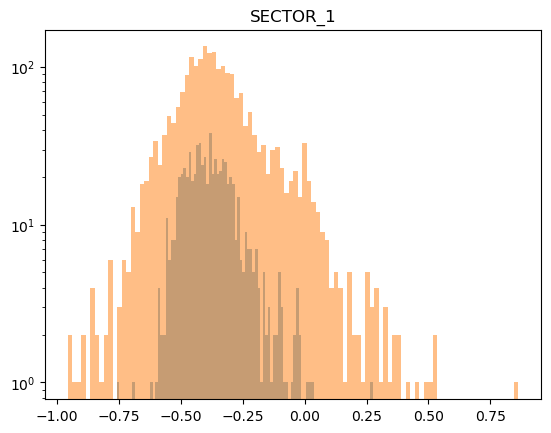

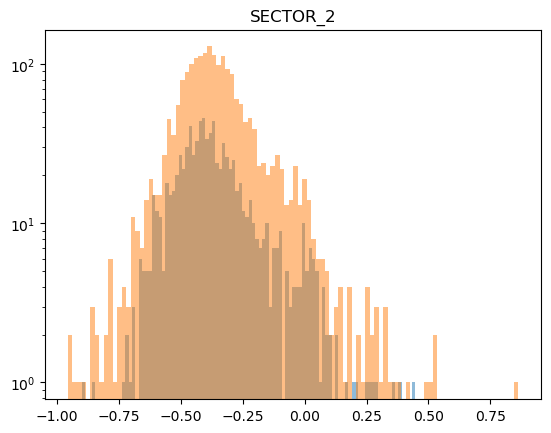

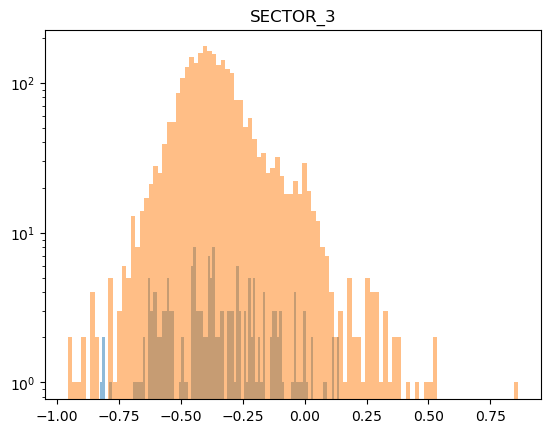

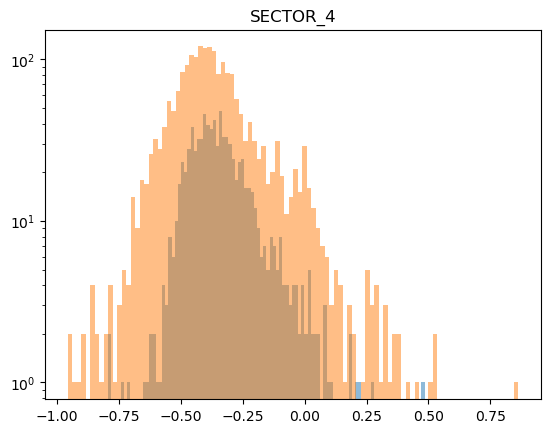

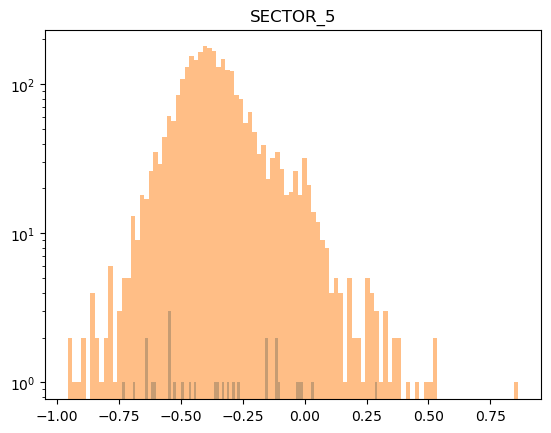

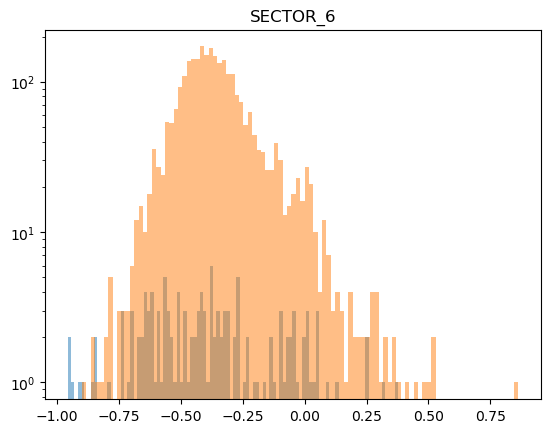

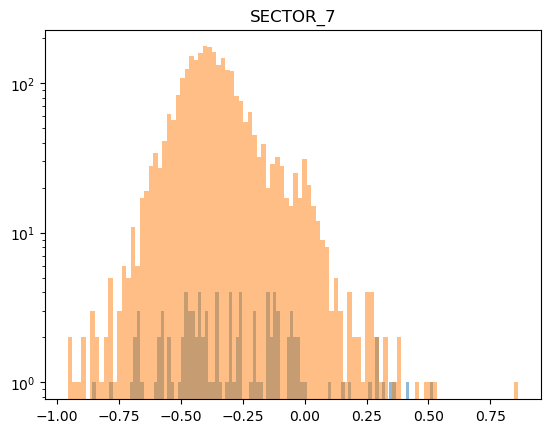

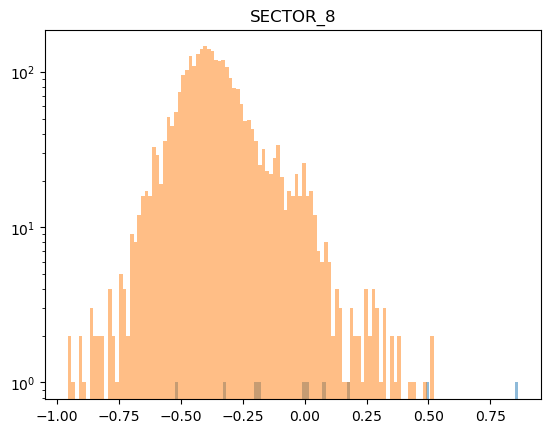

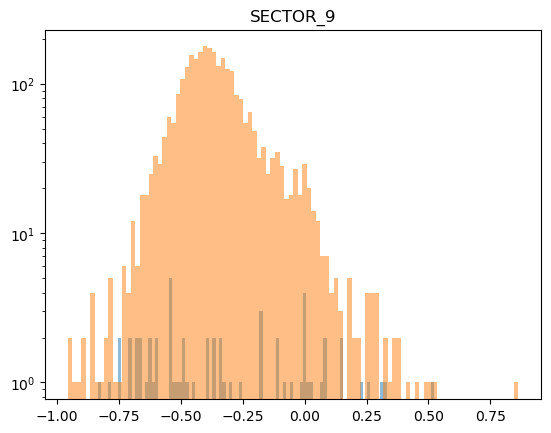

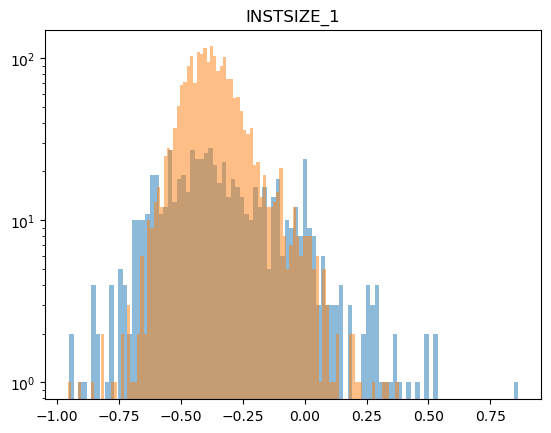

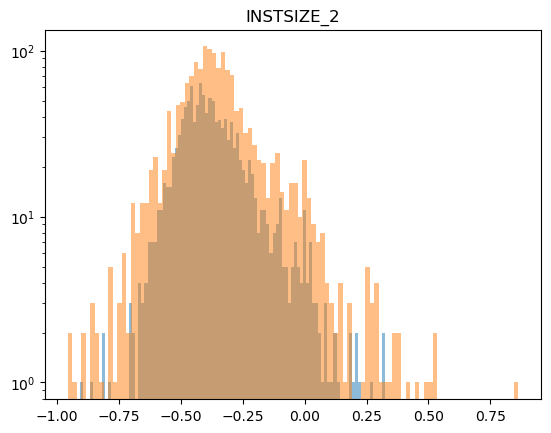

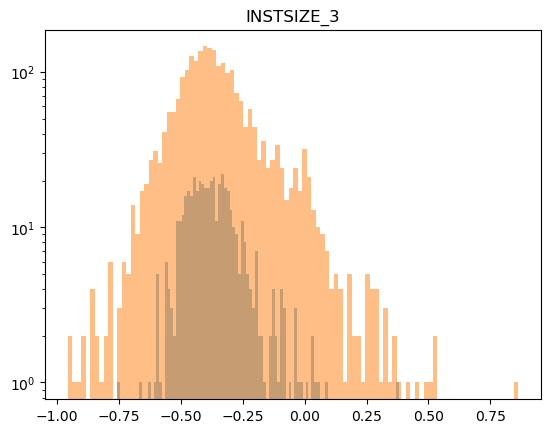

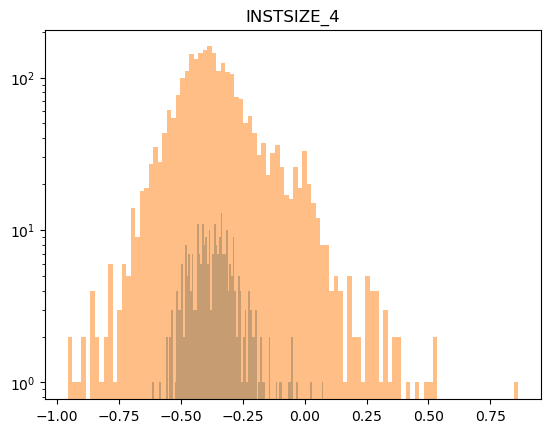

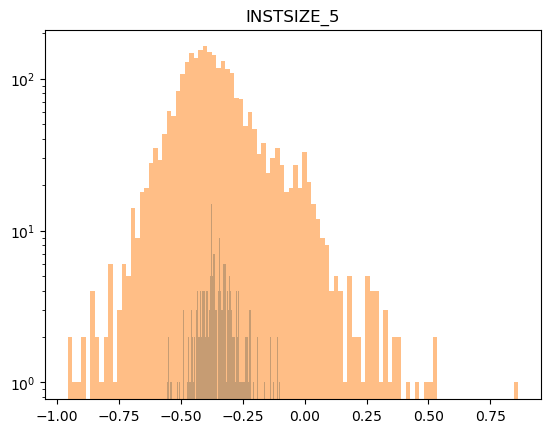

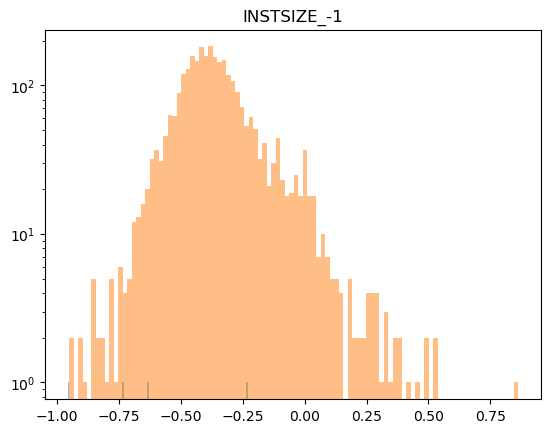

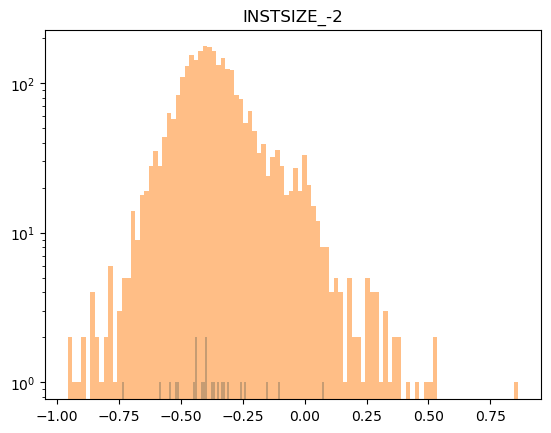

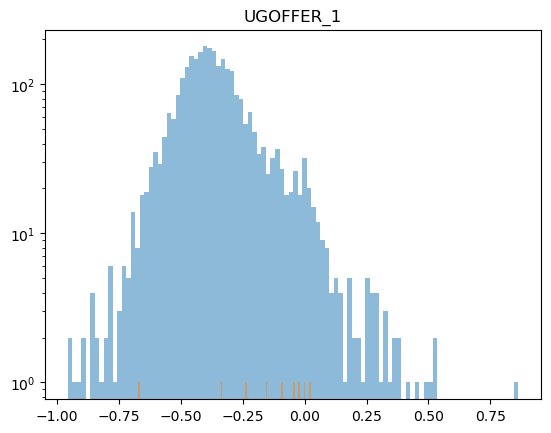

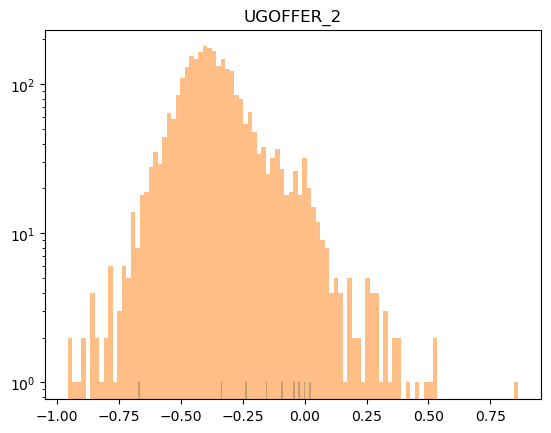

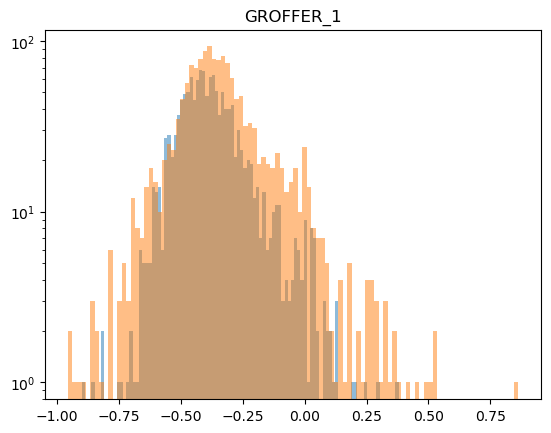

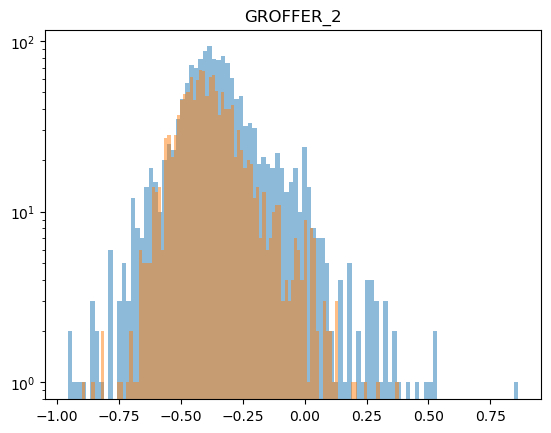

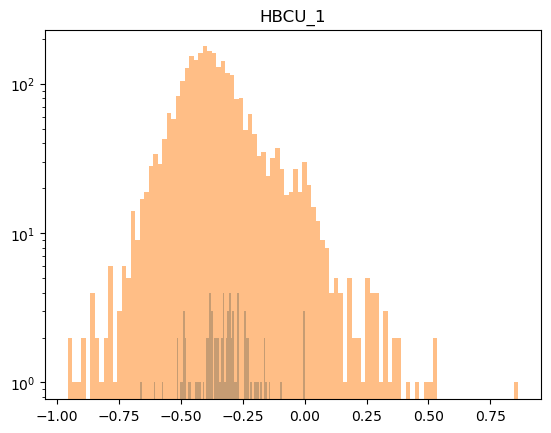

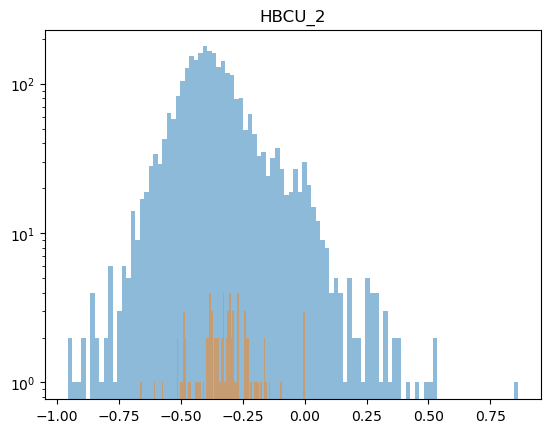

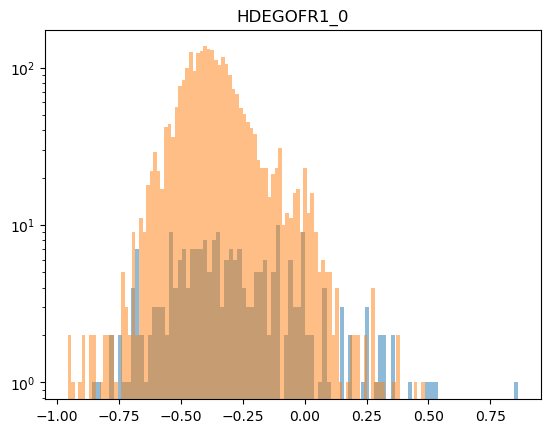

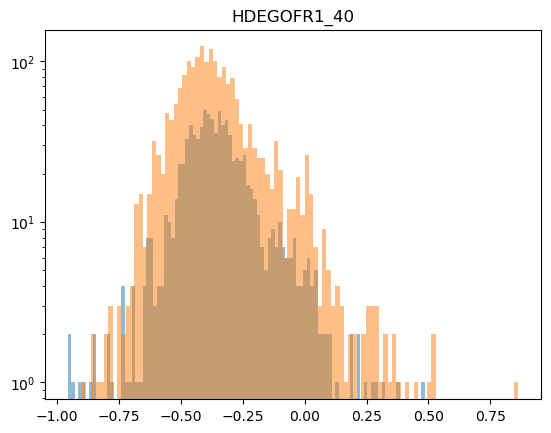

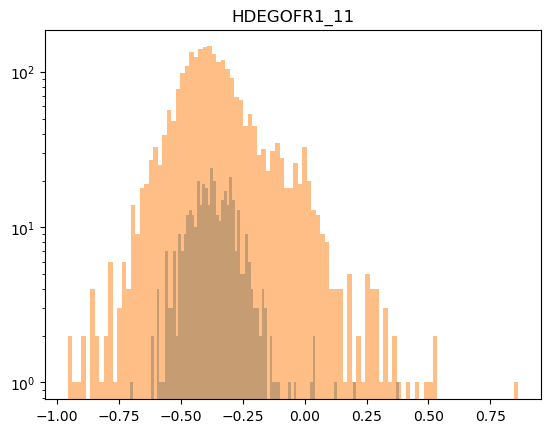

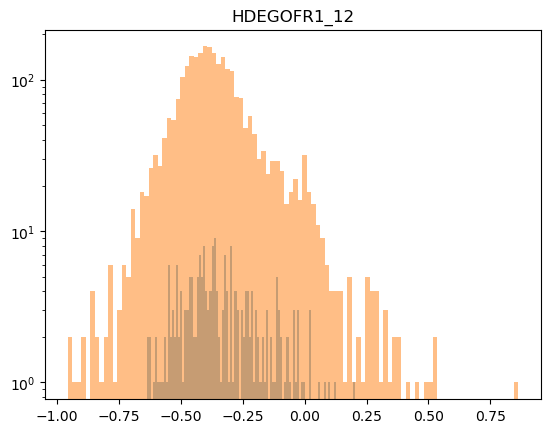

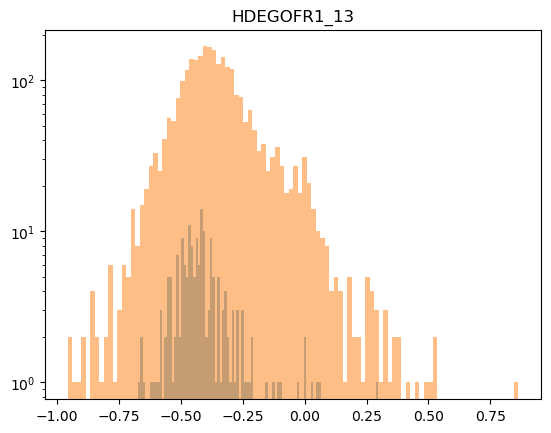

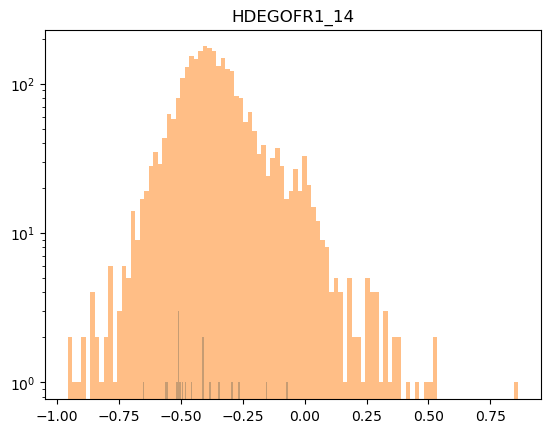

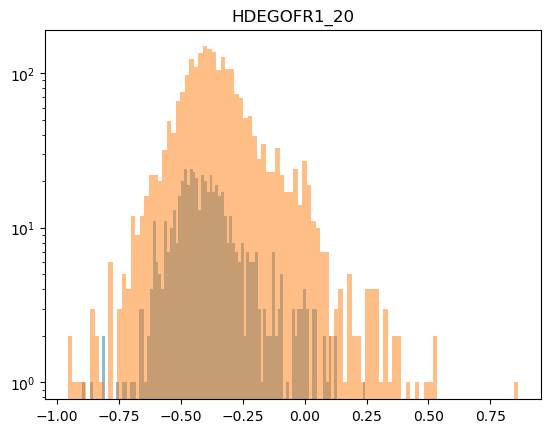

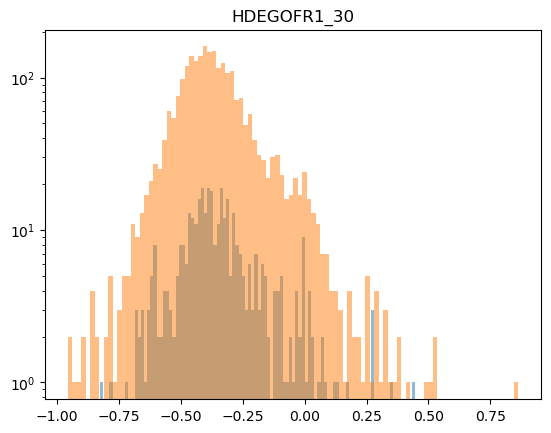

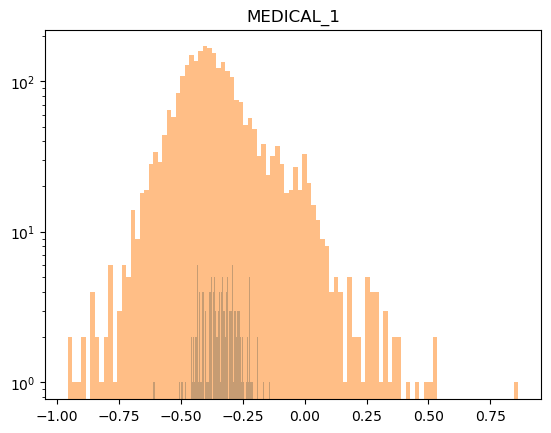

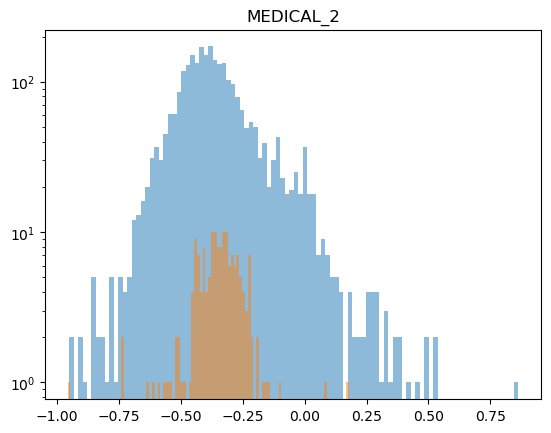

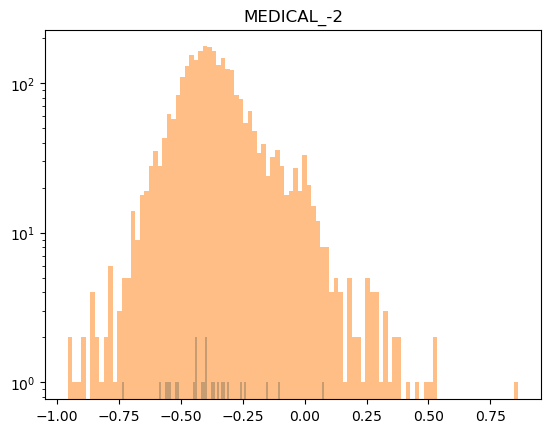

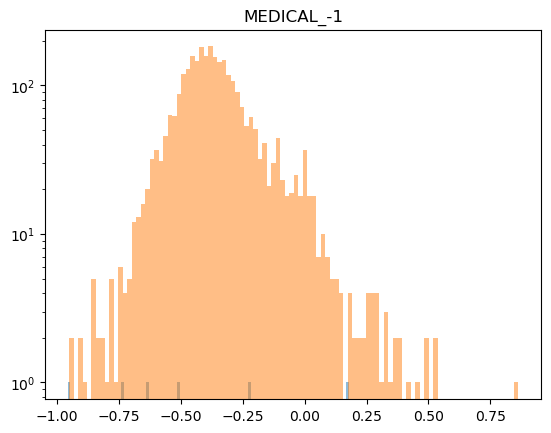

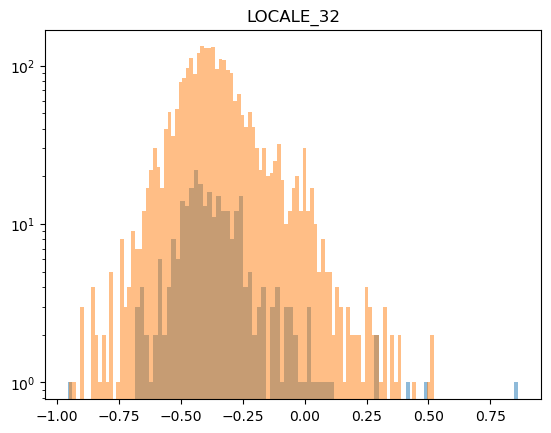

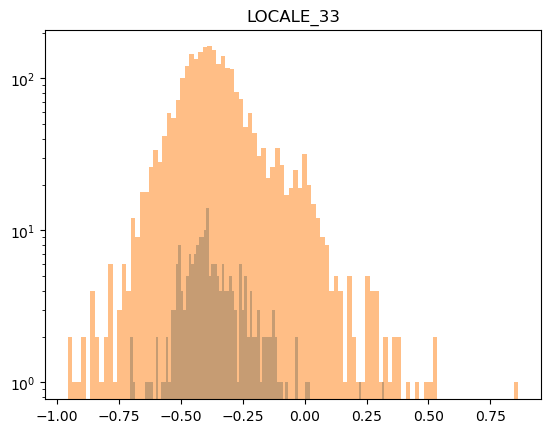

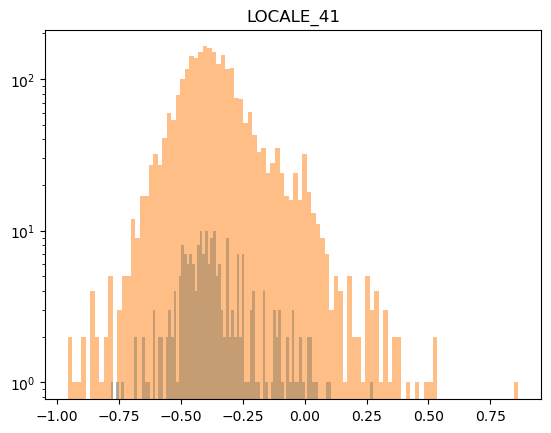

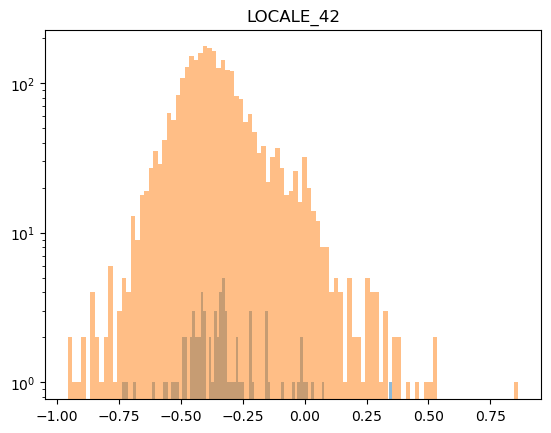

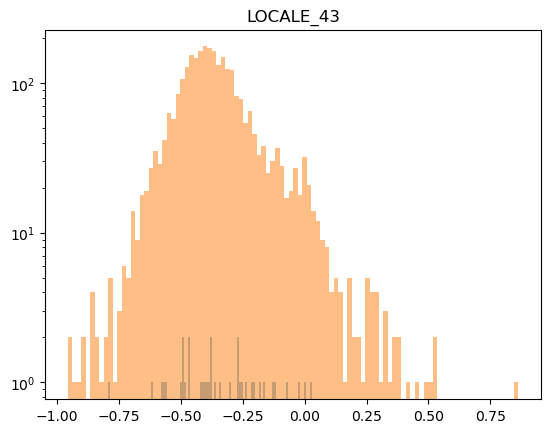

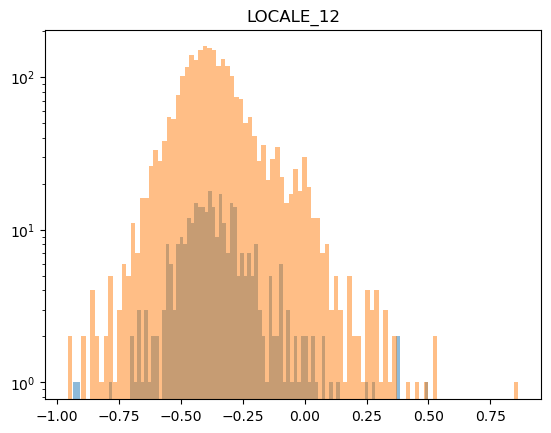

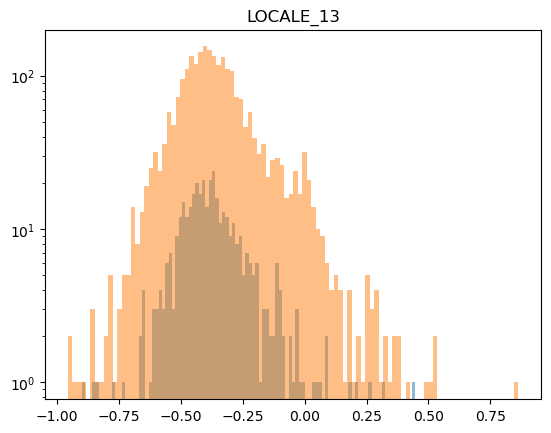

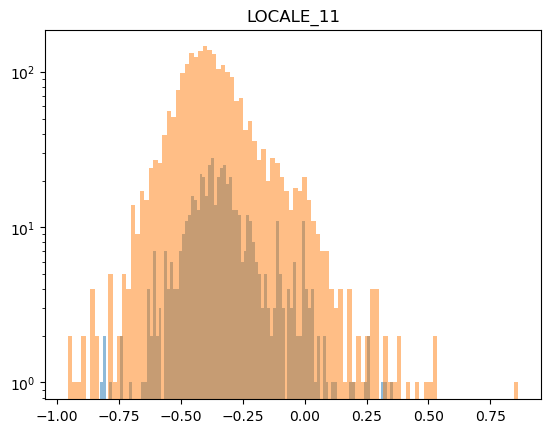

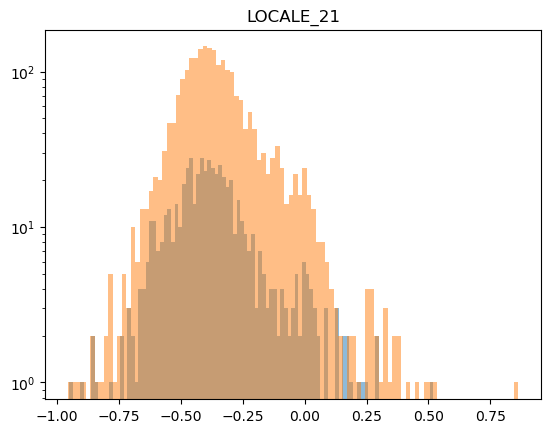

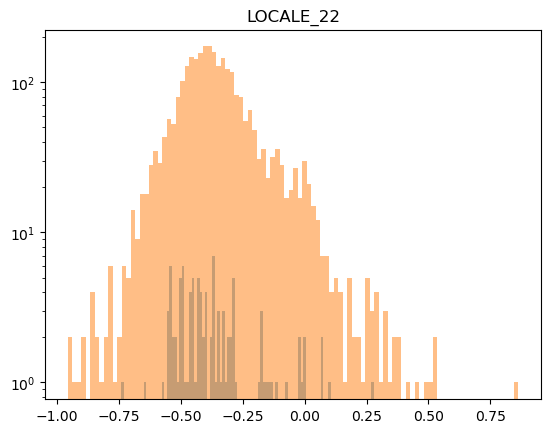

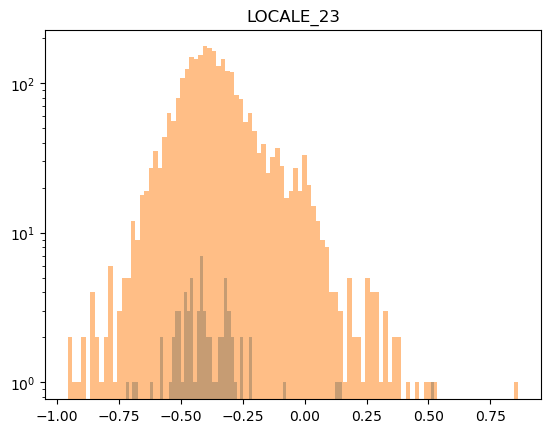

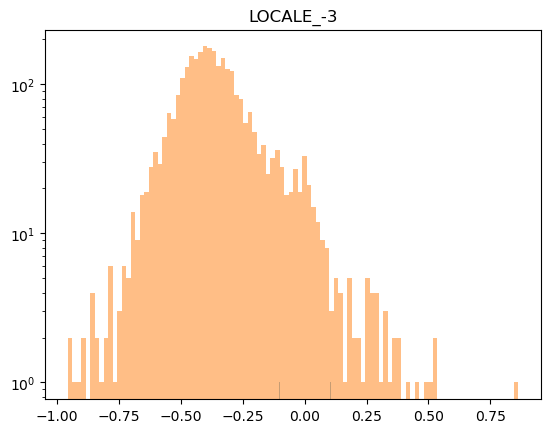

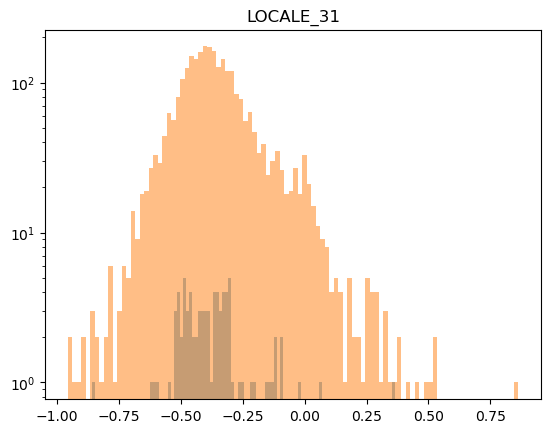

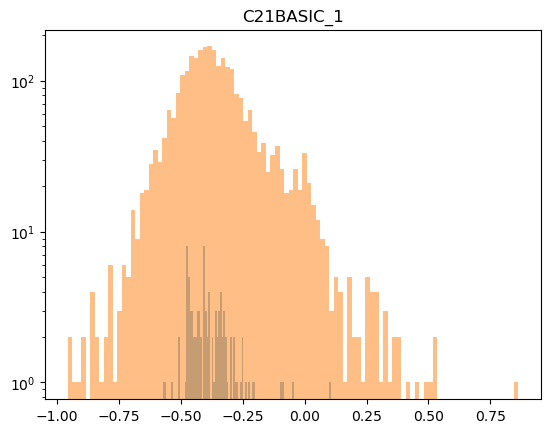

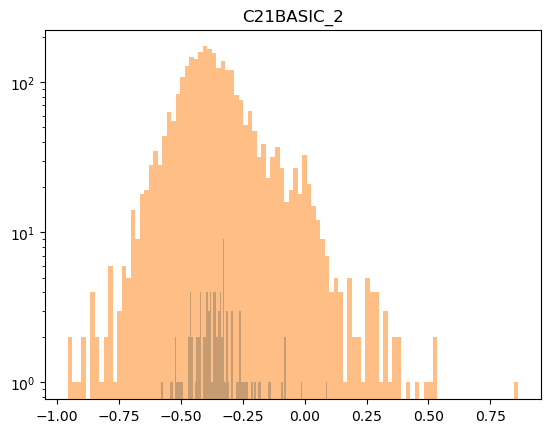

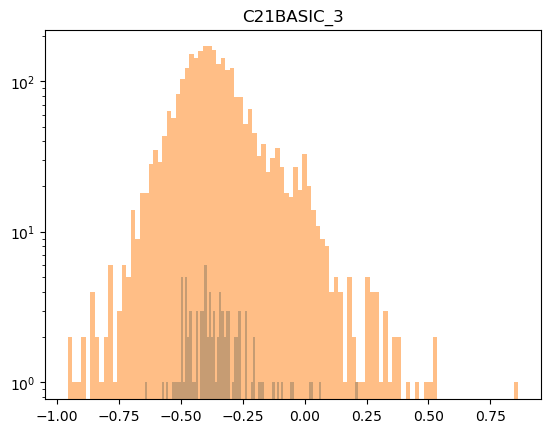

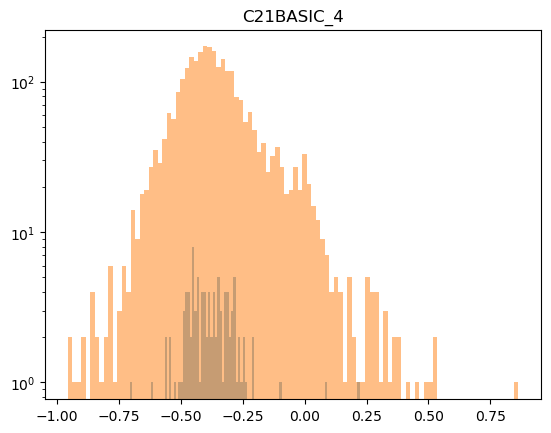

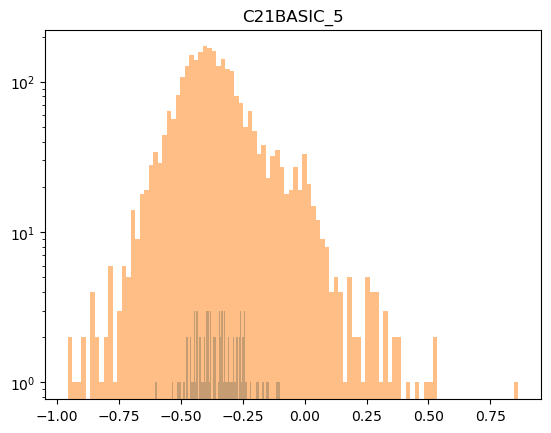

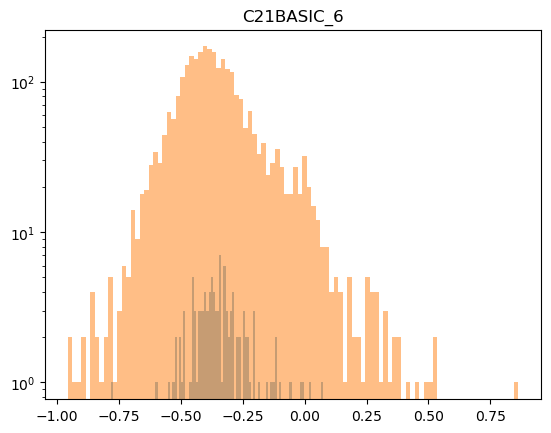

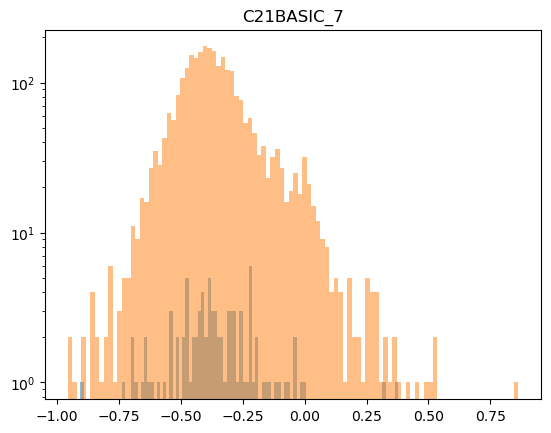

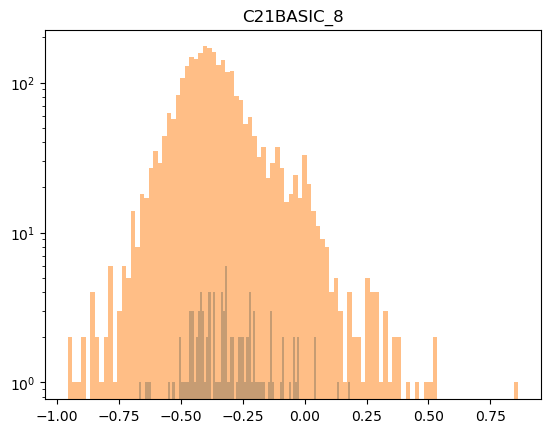

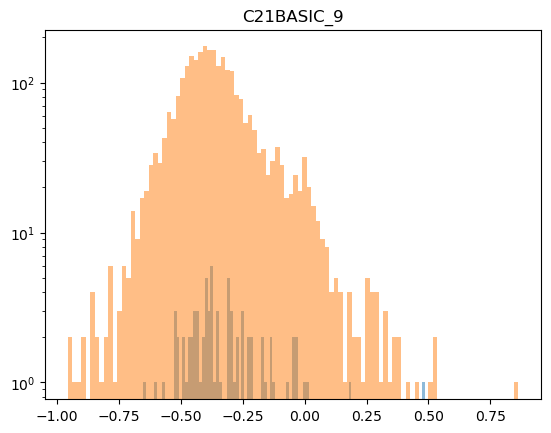

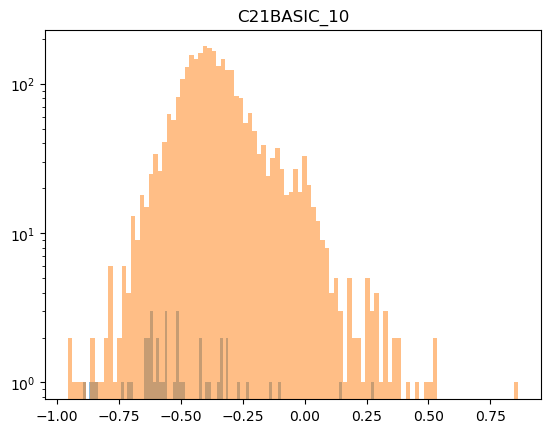

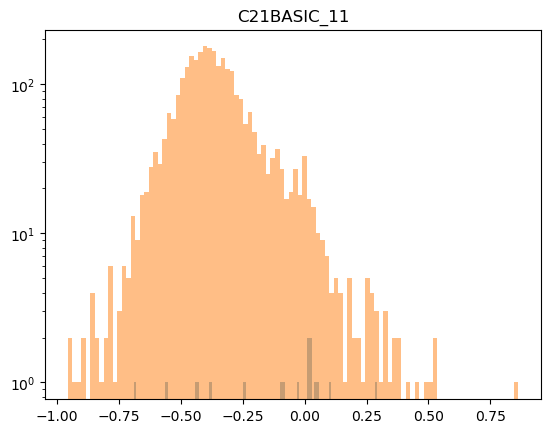

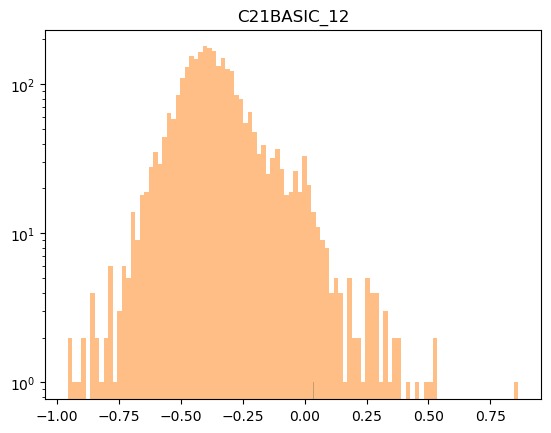

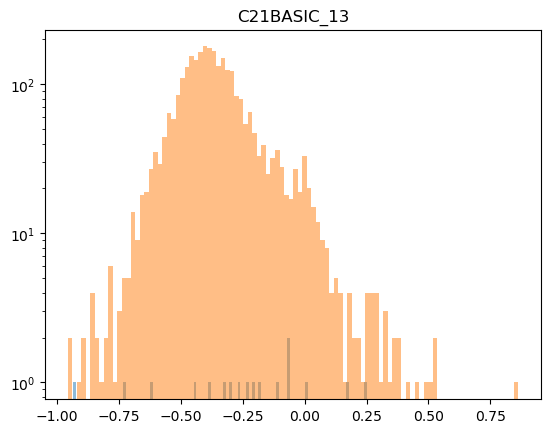

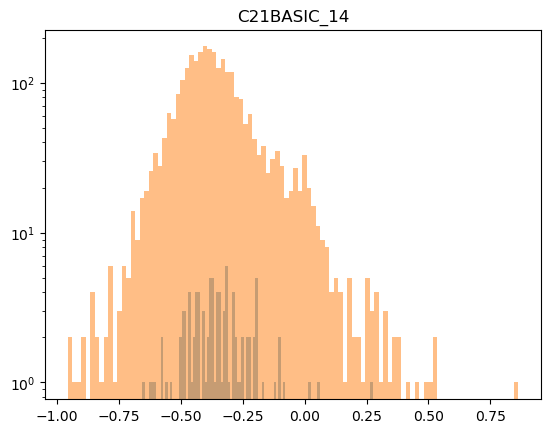

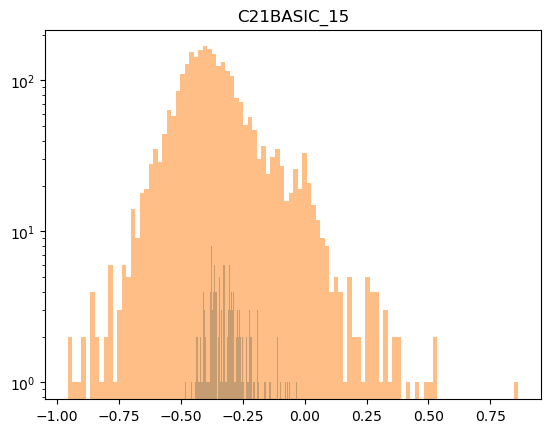

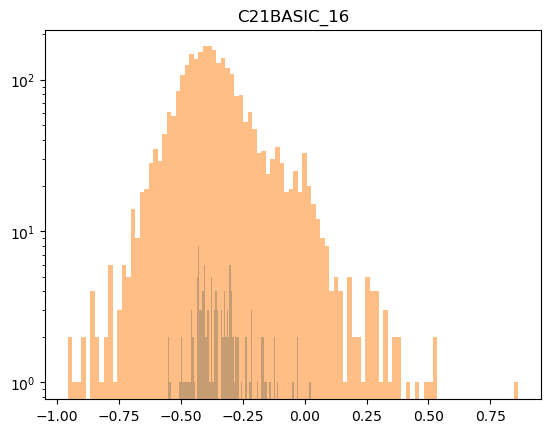

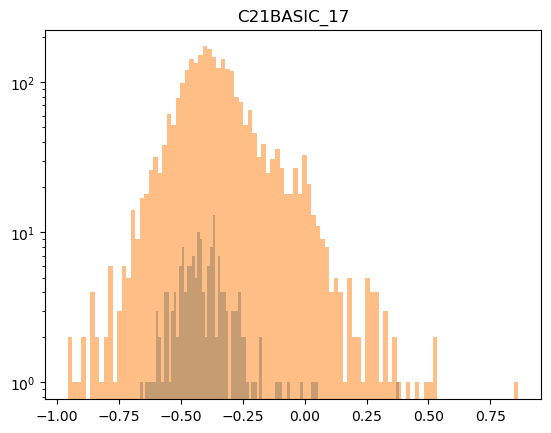

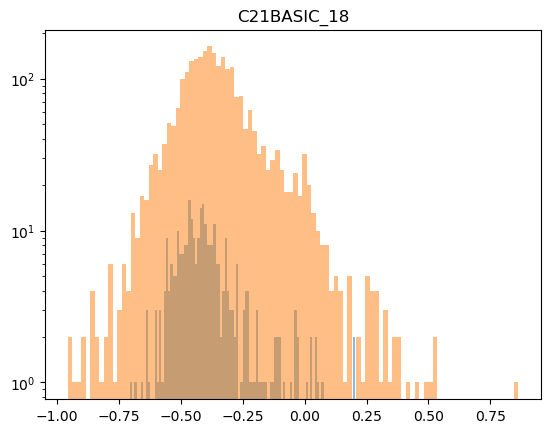

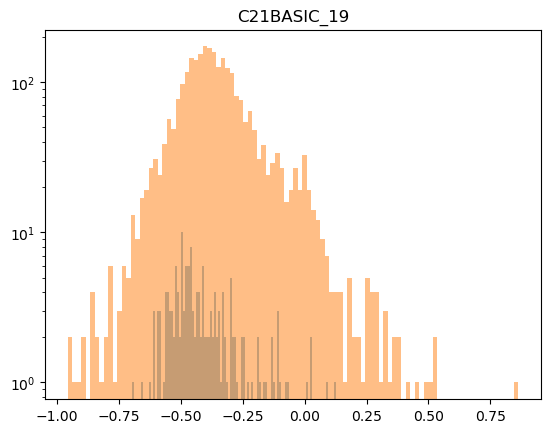

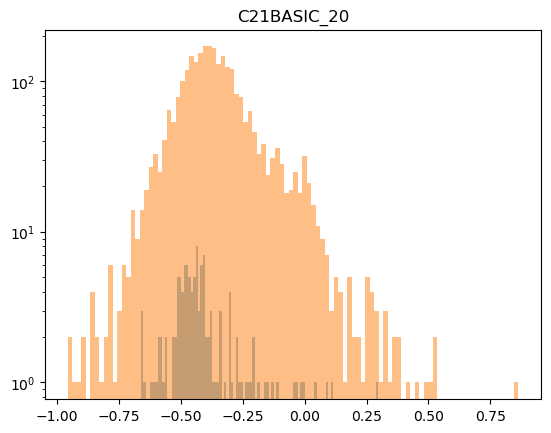

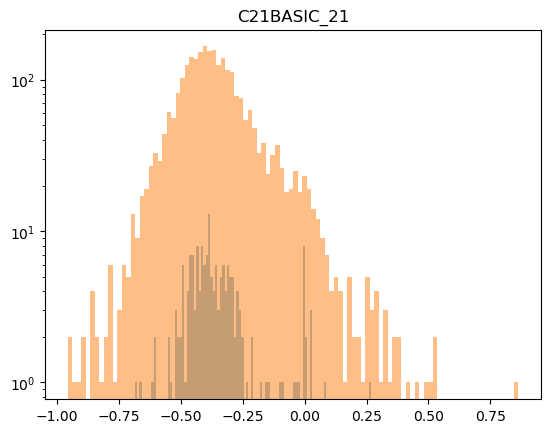

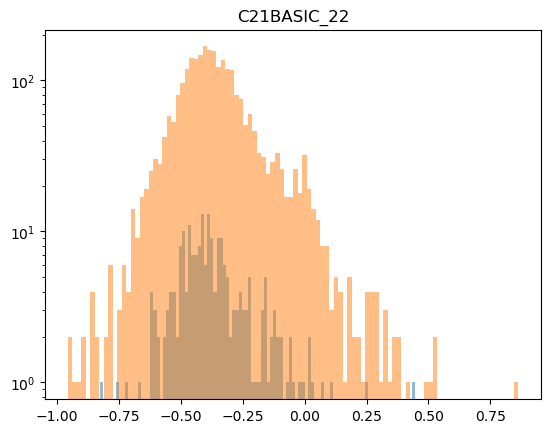

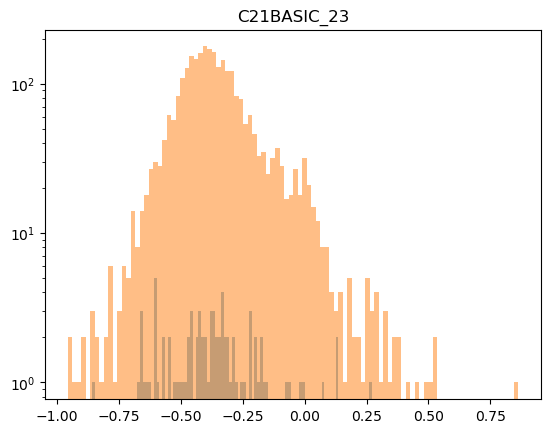

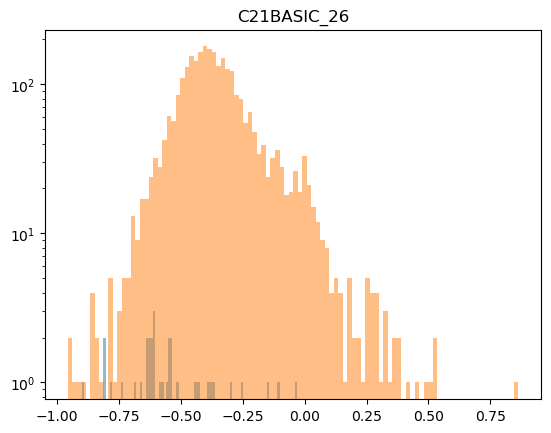

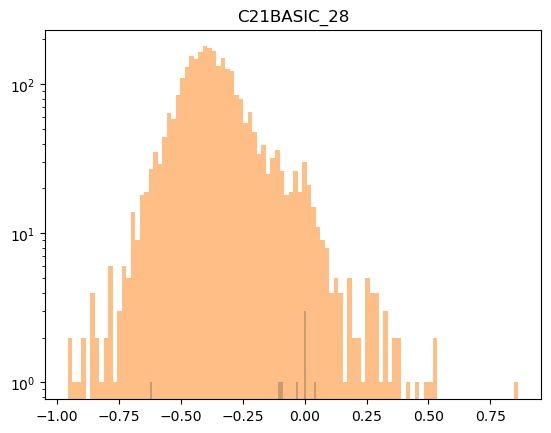

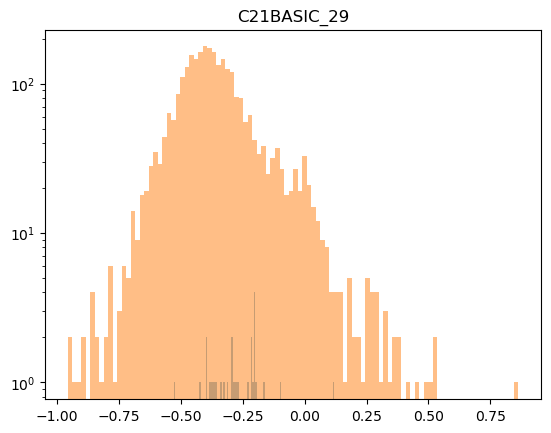

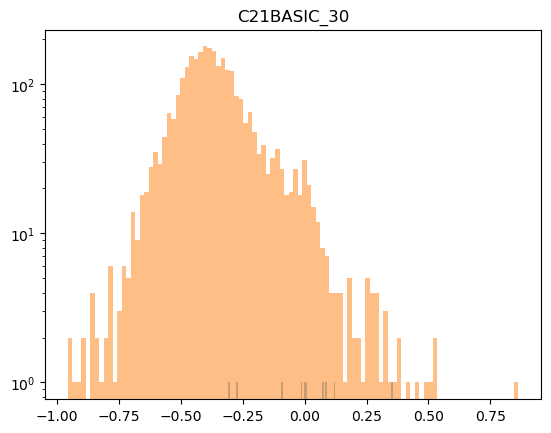

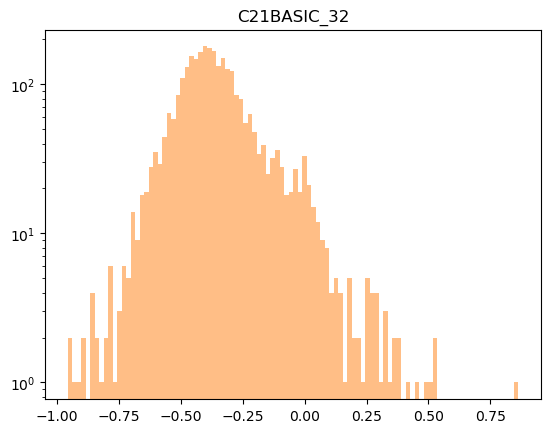

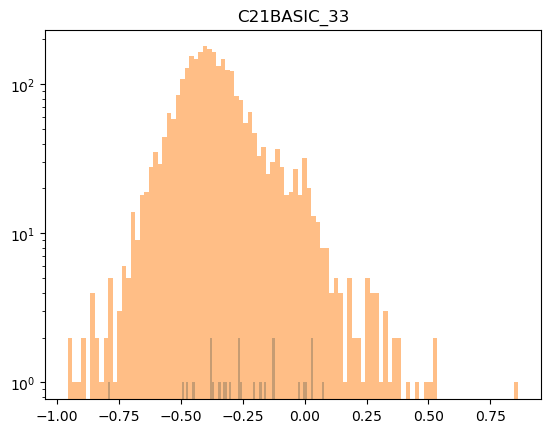

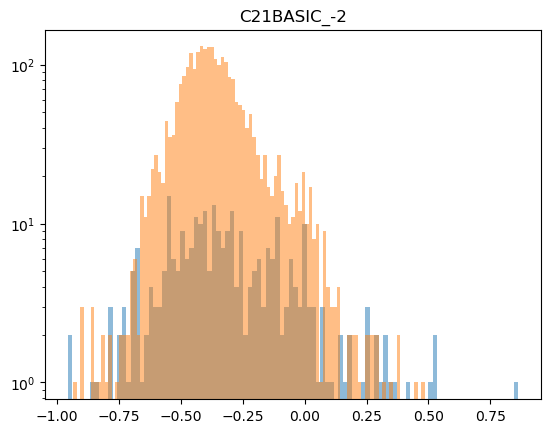

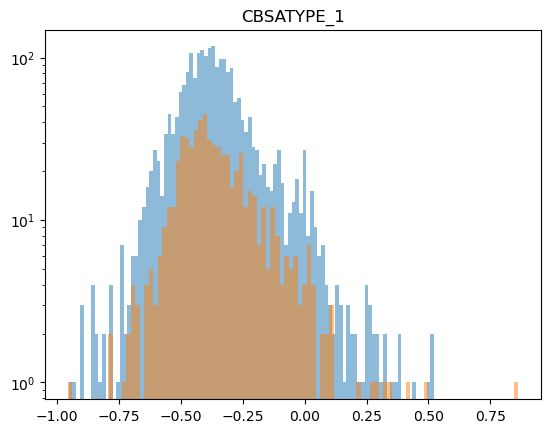

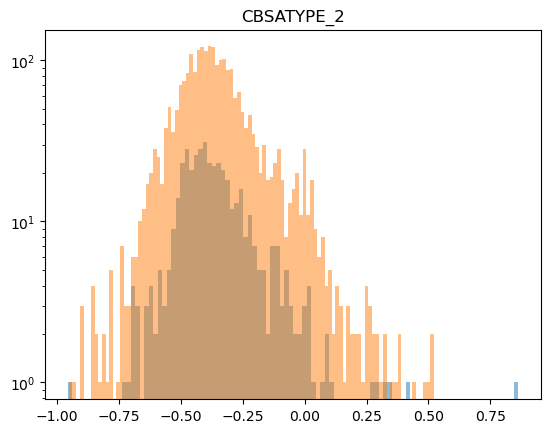

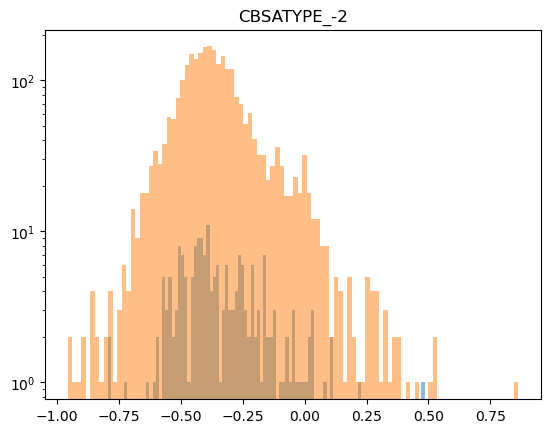

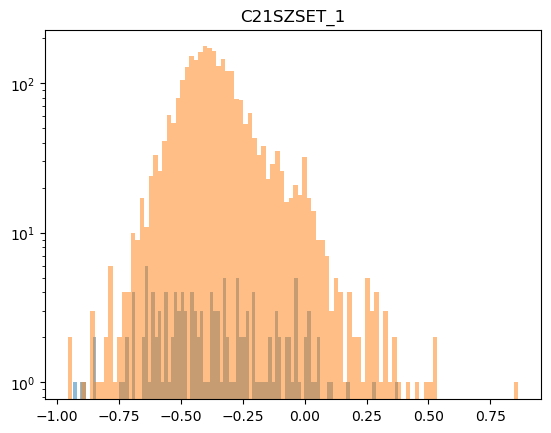

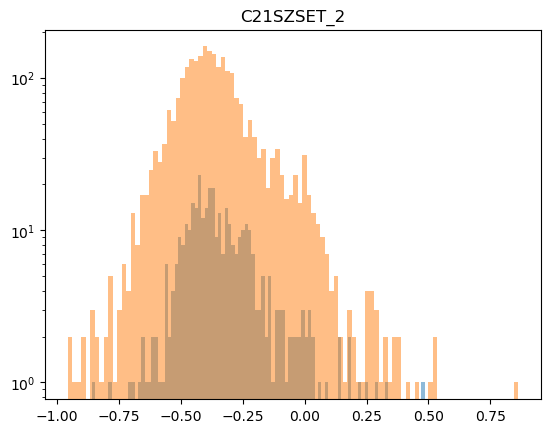

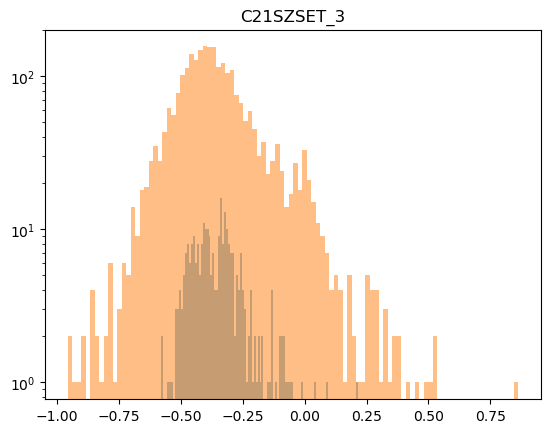

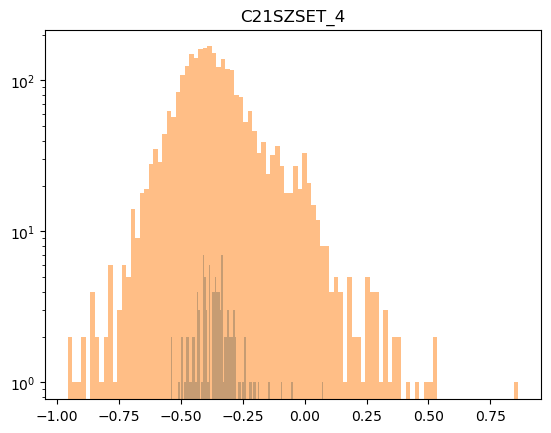

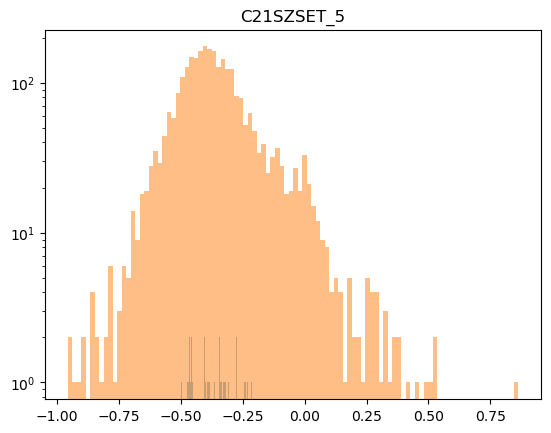

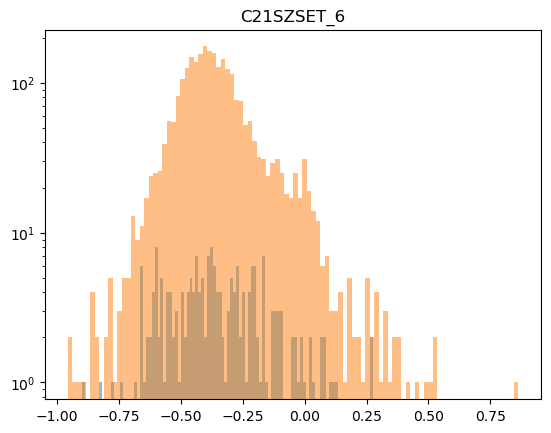

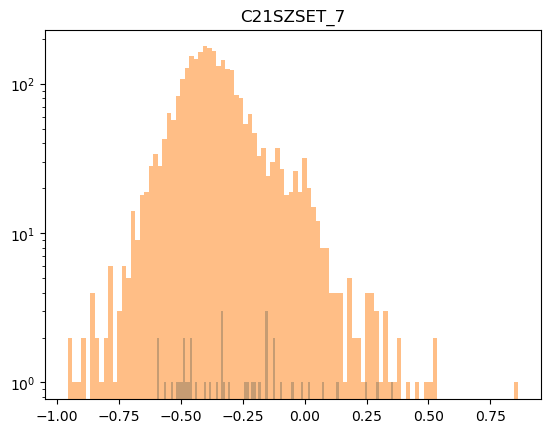

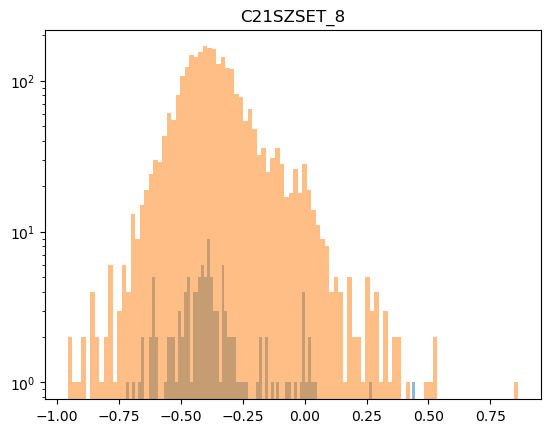

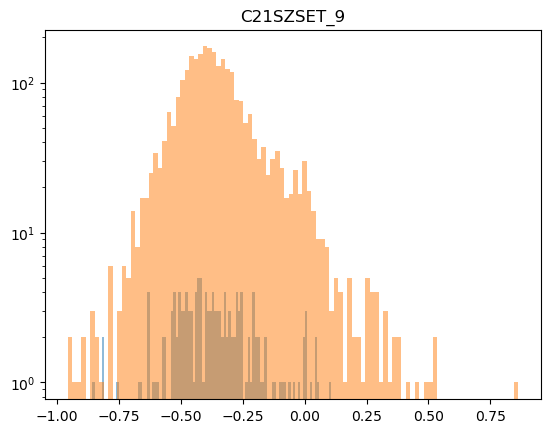

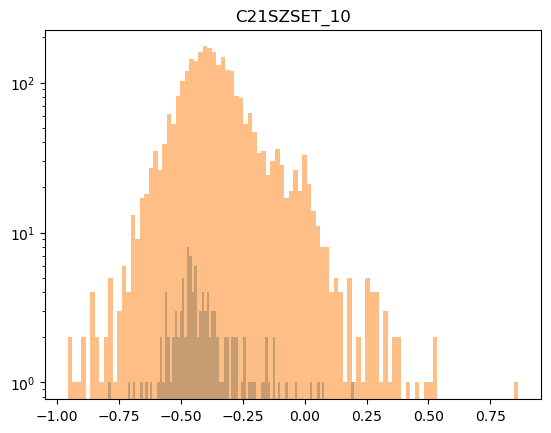

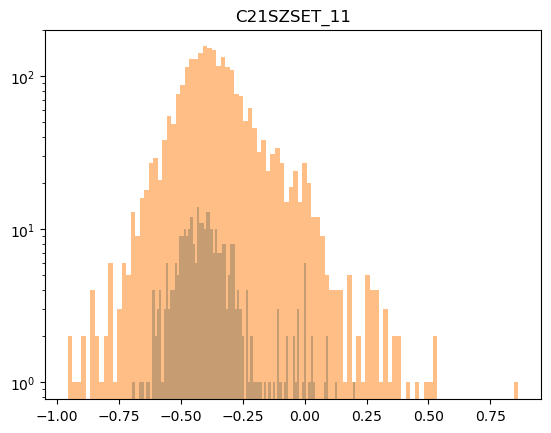

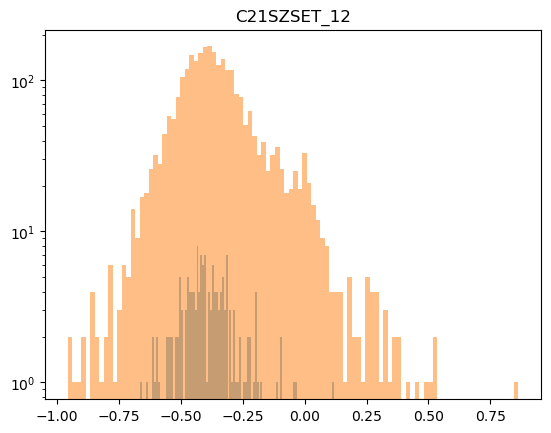

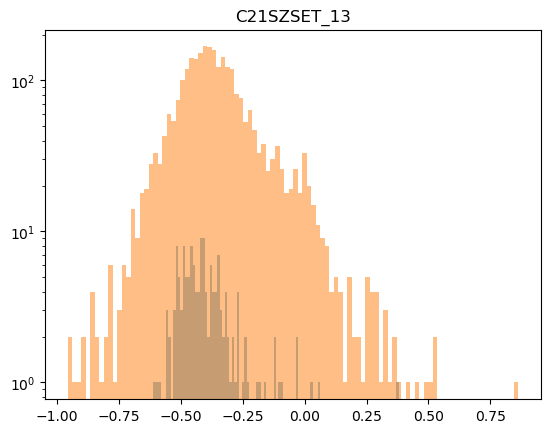

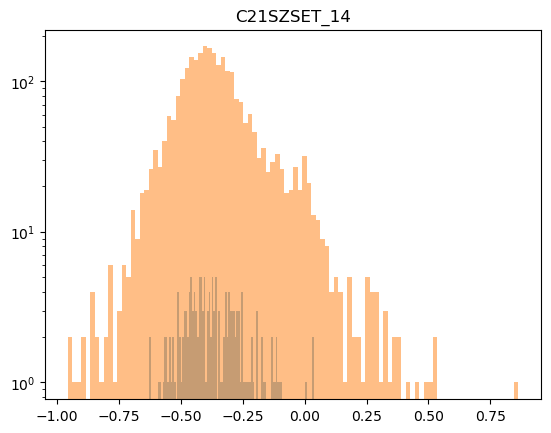

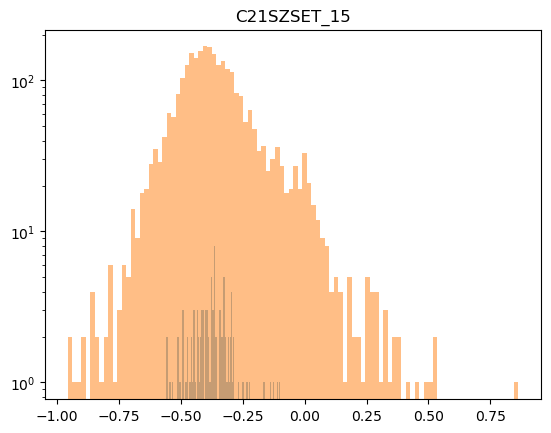

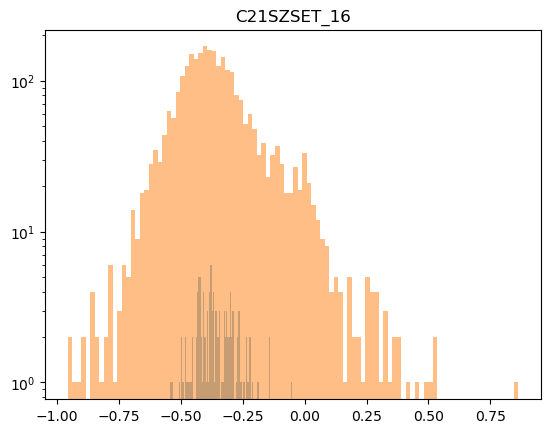

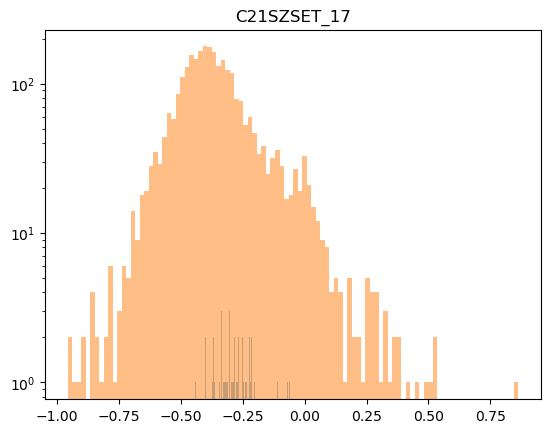

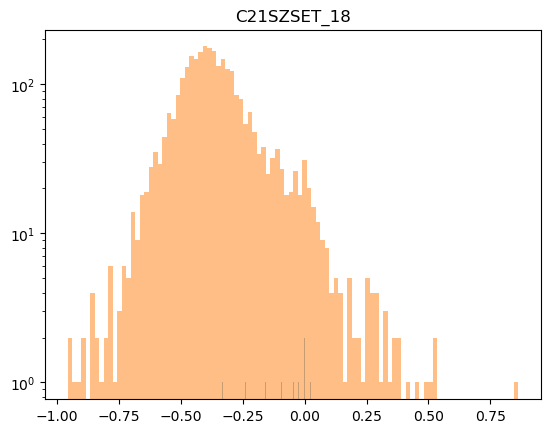

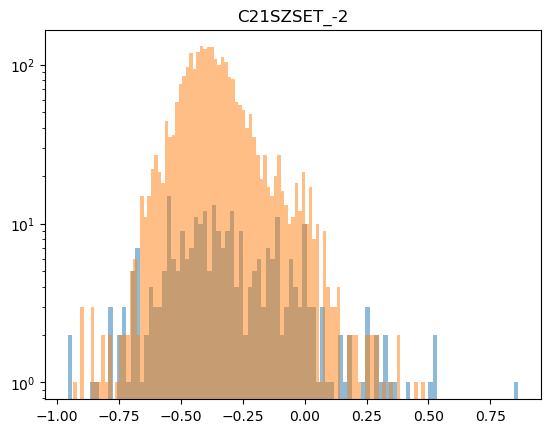

<Figure size 640x480 with 0 Axes>